In [1]:
#TODO
#Portare a fattor comune le logiche di TrainTest - Live

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split


from datetime import date, timedelta
import yfinance as yf #Alternative package if webreader does not work: pip install yfinance
import numpy as np # Fundamental package for scientific computing with Python
import joblib
from lib.Measures import measureDataframe2
from lib.Utility import exportExcelWithTimeStamp
import plotly.express as px
from plotly import graph_objects as go


commissioni = 0.0008


In [3]:
tomorrow = date.today() - timedelta(30)

data = yf.download (tickers = "^SPX", start = "1990-09-04",
                              end = tomorrow, interval = "1d").reset_index()
vix = yf.download (tickers = "^VIX", start = "1990-09-04",
                              end = tomorrow, interval = "1d").reset_index()
vvix = yf.download (tickers = "^VVIX", start = "1990-09-04",
                              end = tomorrow, interval = "1d").reset_index()

data['feat_Open'] = data['Open']

vix['feat_vixOpen'] = vix['Open']
vix['feat_vixPrevClose'] = vix['Close'].shift(1)
vvix['feat_vvixOpen'] = vvix['Open']
vvix['feat_vvixPrevClose'] = vvix['Close'].shift(1)
# data['feat_VolChange'] = (data['Volume'].shift(1) - data['Volume'].shift(2)) / data['Volume'].shift(2)
# data['feat_prevClose'] = data['Close'].shift(1)
# data['bigBodyRange'] = np.where(abs(data['Close'] - data['Open'])/data['Open'] > 0.004, 1, 0)
# vix['feat_Prova'] = 1000*(vix['High'].shift(1)-vix['Low'].shift(1))/vix['Open']
vvix['feat_Acc'] = np.where(vvix['Close'].shift(1) > vvix['Close'].shift(2), 1, 0)
vix = vix.drop(['Open','Close', 'High','Low', 'Adj Close', 'Volume'], axis=1)
vvix = vvix.drop(['Open','Close', 'High','Low', 'Adj Close', 'Volume'], axis=1)
data = data.merge(vix, how='left', on='Date')# VIX
data = data.merge(vvix, how='left', on='Date')# vVIX
data['Cluster'] = np.where(data['Close'] > data['Open'], 1, -1)
# data['Cluster'] = np.where(data['Close'] > data['Open']+data['Open']*0.001, 1, np.where(data['Close'] < data['Open']-data['Open']*0.001, -1,0))
data['feat_PrevCluster'] = data['Cluster'].astype('Int64').shift(1)
data['feat_bigBodyRange'] = np.where(abs(data['Close'] - data['Open'])/data['Open'] > 0.01, 1, 0)

# data['feat_PrevBody'] = 100000*(data['Close'].shift(1)-data['Open'].shift(10))/data['Open'].shift(10)

data =data.dropna()
data.tail(10)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,feat_Open,feat_vixOpen,feat_vixPrevClose,feat_vvixOpen,feat_vvixPrevClose,feat_Acc,Cluster,feat_PrevCluster,feat_bigBodyRange
8471,2024-04-22,4987.330078,5038.839844,4969.399902,5010.600098,5010.600098,3820250000,4987.330078,18.590000,18.709999,95.599998,99.089996,1.0,1,-1,0
8472,2024-04-23,5028.850098,5076.120117,5027.959961,5070.549805,5070.549805,3751400000,5028.850098,16.719999,16.940001,87.379997,89.540001,0.0,1,1,0
8473,2024-04-24,5084.859863,5089.479980,5047.020020,5071.629883,5071.629883,3656740000,5084.859863,15.760000,15.690000,82.699997,82.360001,0.0,-1,1,0
8474,2024-04-25,5019.879883,5057.750000,4990.580078,5048.419922,5048.419922,3958050000,5019.879883,16.250000,15.970000,90.379997,83.610001,1.0,1,-1,0
8475,2024-04-26,5084.649902,5114.620117,5073.140137,5099.959961,5099.959961,3604140000,5084.649902,15.490000,15.370000,82.580002,82.540001,0.0,1,1,0
8476,2024-04-29,5114.129883,5123.490234,5088.649902,5116.169922,5116.169922,3447450000,5114.129883,15.370000,15.030000,80.059998,79.559998,0.0,1,1,0
8477,2024-04-30,5103.779785,5110.830078,5035.310059,5035.689941,5035.689941,4082470000,5103.779785,14.820000,14.670000,79.440002,78.220001,0.0,-1,1,1
8478,2024-05-01,5029.029785,5096.120117,5013.450195,5018.390137,5018.390137,4544170000,5029.029785,15.750000,15.650000,83.570000,81.820000,1.0,-1,-1,0
8479,2024-05-02,5049.319824,5073.209961,5011.049805,5064.200195,5064.200195,4381660000,5049.319824,15.140000,15.390000,80.300003,81.930000,1.0,1,-1,0
8480,2024-05-03,5122.779785,5139.120117,5101.220215,5127.790039,5127.790039,3924990000,5122.779785,14.510000,14.680000,75.430000,78.589996,0.0,1,1,0


In [4]:
features = [col for col in data.columns if 'feat' in col]
print(features)

# split_test_date = '2019-02-21'
# start_date = '1990-09-04'

# label = 'Cluster'

# train_data = data[(data['Date'] < split_test_date) & (data['Date'] > start_date)].reset_index(drop=True)
# train_data = data[data['Date'] >= split_test_date].reset_index(drop=True)

# x_train = train_data[features]
# y_train = train_data['Cluster']

# x_test = train_data[features]
# y_test = train_data['Cluster']
# print(train_data)

x_train, x_test, y_train, y_test = train_test_split(data[features], data['Cluster'], test_size= 0.3, random_state= 0)

x_train = x_train.sort_index()
x_test = x_test.sort_index()
y_train= y_train.sort_index()
y_test = y_test.sort_index()


print (f'X_train: {x_train.shape} \nX_test: {x_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}')

['feat_Open', 'feat_vixOpen', 'feat_vixPrevClose', 'feat_vvixOpen', 'feat_vvixPrevClose', 'feat_Acc', 'feat_PrevCluster', 'feat_bigBodyRange']
X_train: (3047, 8) 
X_test: (1307, 8) 
y_train: (3047,) 
y_test: (1307,)


In [5]:
# Train the model
from sklearn.linear_model import LogisticRegression

# Set regularization rate
reg = 0.01

# train a logistic regression model on the training set
model = LogisticRegression(C=1/reg, solver="liblinear", random_state=42).fit(x_train, y_train)

joblib.dump(model, "./logRegression-sp2.joblib")

print (model)

LogisticRegression(C=100.0, random_state=42, solver='liblinear')


In [6]:
predictions = model.predict(x_train)
print(predictions)

[ 1 -1  1 ...  1  1  1]


In [7]:
from sklearn.metrics import accuracy_score
df = x_train.copy()

df['predictions'] = predictions
df['y_train'] = y_train

# df.to_excel('pippo.xlsx')
print(f"Accuracy score: {accuracy_score(df['y_train'], df['predictions'])}")

Accuracy score: 0.6498194945848376


In [8]:
from sklearn.metrics import classification_report

# print(classification_report(y_test, predictions))

In [9]:
# from sklearn.metrics import precision_score, recall_score

# print("Overall Precision:",precision_score(y_test, predictions))
# print("Overall Recall:",recall_score(y_test, predictions))

# from sklearn.metrics import roc_curve
# from sklearn.metrics import confusion_matrix

# # calculate ROC curve
# fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# # plot ROC curve
# fig = plt.figure(figsize=(6, 6))
# # Plot the diagonal 50% line
# plt.plot([0, 1], [0, 1], 'k--')
# # Plot the FPR and TPR achieved by our model
# plt.plot(fpr, tpr)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.show()

# from sklearn.metrics import roc_auc_score

# auc = roc_auc_score(y_test,y_scores[:,1])
# print('AUC: ' + str(auc))

In [10]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix
# cm = confusion_matrix(y_test, predictions)
# print (cm)

In [11]:
y_scores = model.predict_proba(x_test)
print(y_scores)

[[0.57232218 0.42767782]
 [0.51450871 0.48549129]
 [0.15338036 0.84661964]
 ...
 [0.38203388 0.61796612]
 [0.72693041 0.27306959]
 [0.44142713 0.55857287]]


Misure per 12.695833333333333 anni
Benchmark Equity: 1146.3258056640625
Equity 12521.165419921881
Maximum number of loss operation: 11
Maximum DrawDown: -595.0553652343806
SGR: 986.2421072468827 vs Benchmark: 90.29149765650641
Win Rate: 59.23859533967837
Long Equity 9713.187133789062
Short Equity 8566.861328125


C:\Users\vitto\AppData\Local\Temp\ipykernel_26768\3223695704.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['cluster'] = y_train_pred


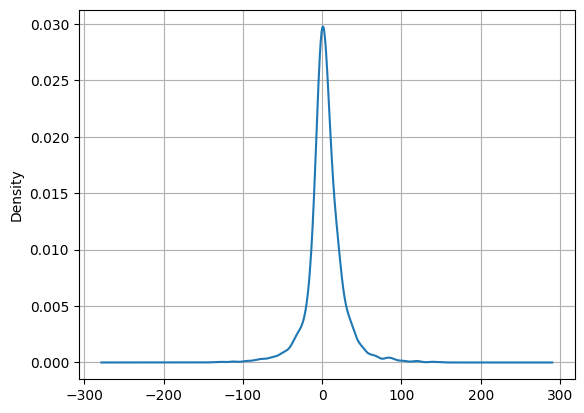

In [12]:

# Seleziona le colonne con il prefisso "feat"
feat_cols = [col for col in data.columns if 'feat' in col]

# print(x_train.index)
# print(data.index)

y_train_pred = model.predict(x_train.sort_index())

train_data = data[data.index.isin(x_train.index)]
train_data['cluster'] = y_train_pred


df_train = pd.DataFrame(train_data)
df_train['color'] = np.where(train_data['cluster']==1,'green','red')

# Calcoliamo la variazione percentuale dei prezzi di chiusura
#df_live['pct_change'] = df_live['Close'].pct_change()
df_train['pct_change'] = (df_train['Close']-df_train['Open'])#/df_live['Open']
df_train['signal'] = np.where(df_train['cluster'] == 1, 1, np.where(df_train['cluster'] == -1, -1, 0))
df_train['commissione'] = abs(df_train['cluster'])*commissioni*df_train['Open']
df_train['gain'] = (df_train['cluster']*df_train['pct_change'])-df_train['commissione']
# df_live['gainVolFilter'] = np.where(df_live['bigBodyRangePred'] == 1, (df_live['signal']*df_live['pct_change'])-commissioni, 0)
df_train['longGain'] = np.where(df_train['cluster'] == 1,df_train['cluster']*df_train['pct_change'], 0)
df_train['shortGain'] = np.where(df_train['cluster'] == -1, df_train['cluster']*df_train['pct_change'], 0)  
df_train['equity'] = np.cumsum(df_train['gain'])
# df_live['equityVolatilityFilter'] = np.cumsum(df_live['gainVolFilter'])

measureDataframe2(df_train)
exportExcelWithTimeStamp(df_train, "Equity/", "TrainEquity.xlsx")

# LIVE

fig = go.Figure(data=[go.Candlestick(x=train_data['Date'],
                open=train_data['Open'],
                close=train_data['Close'], high=train_data['High'], low=train_data['Low'], opacity=0.5)])
sec_y = go.layout.YAxis(title='Equity')#, offset=dict(type="absolute", value=0.25))
fig.add_scatter(x=train_data['Date'], y=train_data['Open'], mode='markers',marker=dict(color=df_train['color']))
# fig.add_trace(go.Line(x=df['Date'], y=df['equity'], name='Equity'))
# fig.add_trace(go.Scatter(x=df_live['Date'], y=df_live['equityVolatilityFilter'], name='Equity Volatility Filter'))

fig.update_layout(
    xaxis_rangeslider_visible=False,
                  yaxis2=dict(
        title='Equity',
        overlaying='y',  # Sovrappone il secondo asse y al primo
        side='right',  # Posiziona il secondo asse y a destra
        showgrid=False  # Nasconde la griglia per il secondo asse y se necessario
    ))
# Associa la serie Equity al secondo asse y
fig.data[1].update(yaxis='y2')
fig.show()

# Plot distribution of values in Marks column
df_train['gain'].plot(kind='kde')
plt.grid()

C:\Users\vitto\AppData\Local\Temp\ipykernel_26768\797563255.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Misure per 5.445833333333334 anni
Benchmark Equity: 750.12109375
Equity 4806.354673486326
Maximum number of loss operation: 7
Maximum DrawDown: -791.9553460937477
SGR: 882.5746913823398 vs Benchmark: 137.74220543228768
Win Rate: 58.30145371078807
Long Equity 3996.4832153320312
Short Equity 3246.3621215820312


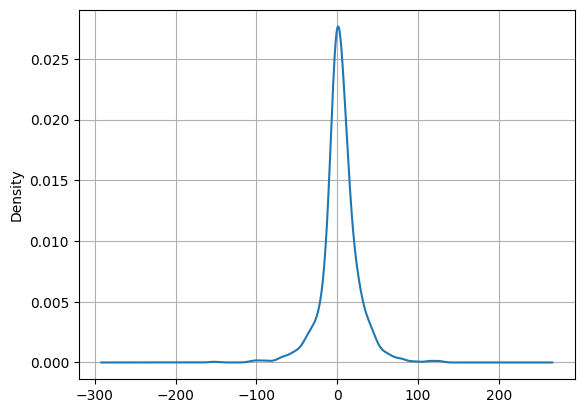

In [13]:

# Seleziona le colonne con il prefisso "feat"
feat_cols = [col for col in data.columns if 'feat' in col]

y_test_pred = model.predict(x_test.sort_index())

test_data = data[data.index.isin(x_test.index)]
test_data['cluster'] = y_test_pred


df_test = pd.DataFrame(test_data)
df_test['color'] = np.where(test_data['cluster']==1,'green','red')

# Calcoliamo la variazione percentuale dei prezzi di chiusura
#df_live['pct_change'] = df_live['Close'].pct_change()
df_test['pct_change'] = (df_test['Close']-df_test['Open'])#/df_live['Open']
df_test['signal'] = np.where(df_test['cluster'] == 1, 1, np.where(df_test['cluster'] == -1, -1, 0))
df_test['commissione'] = abs(df_test['cluster'])*commissioni*df_test['Open']
df_test['gain'] = (df_test['cluster']*df_test['pct_change'])-df_test['commissione']
# df_live['gainVolFilter'] = np.where(df_live['bigBodyRangePred'] == 1, (df_live['signal']*df_live['pct_change'])-commissioni, 0)
df_test['longGain'] = np.where(df_test['cluster'] == 1,df_test['cluster']*df_test['pct_change'], 0)
df_test['shortGain'] = np.where(df_test['cluster'] == -1, df_test['cluster']*df_test['pct_change'], 0)  
df_test['equity'] = np.cumsum(df_test['gain'])
# df_live['equityVolatilityFilter'] = np.cumsum(df_live['gainVolFilter'])

measureDataframe2(df_test)
exportExcelWithTimeStamp(df_test, "Equity/", "TestEquity.xlsx")

fig = go.Figure(data=[go.Candlestick(x=test_data['Date'],
                open=test_data['Open'],
                close=test_data['Close'], high=test_data['High'], low=test_data['Low'], opacity=0.5)])
sec_y = go.layout.YAxis(title='Equity')#, offset=dict(type="absolute", value=0.25))
fig.add_scatter(x=test_data['Date'], y=test_data['Open'], mode='markers',marker=dict(color=df_test['color']))
# fig.add_trace(go.Line(x=df['Date'], y=df['equity'], name='Equity'))
# fig.add_trace(go.Scatter(x=df_live['Date'], y=df_live['equityVolatilityFilter'], name='Equity Volatility Filter'))

fig.update_layout(
    xaxis_rangeslider_visible=False,
                  yaxis2=dict(
        title='Equity',
        overlaying='y',  # Sovrappone il secondo asse y al primo
        side='right',  # Posiziona il secondo asse y a destra
        showgrid=False  # Nasconde la griglia per il secondo asse y se necessario
    ))
# Associa la serie Equity al secondo asse y
fig.data[1].update(yaxis='y2')
fig.show()

# Plot distribution of values in Marks column
df_test['gain'].plot(kind='kde')
plt.grid()

In [14]:
test_accuracy = accuracy_score(y_test, y_test_pred)
print(test_accuracy)

0.6411629686304514


### LIVE

In [15]:
before = date.today() - timedelta(30)
tomorrow = date.today() + timedelta(1)

dataLive = yf.download (tickers = "^SPX", start = before,
                              end = tomorrow, interval = "1d").reset_index()
vixLive = yf.download (tickers = "^VIX", start = before,
                              end = tomorrow, interval = "1d").reset_index()
vvixLive = yf.download (tickers = "^VVIX", start = before,
                              end = tomorrow, interval = "1d").reset_index()

vixLive['feat_vixOpen'] = vixLive['Open']
vixLive['feat_vixPrevClose'] = vixLive['Close'].shift(1)
vvixLive['feat_vvixOpen'] = vvixLive['Open']
vvixLive['feat_vvixPrevClose'] = vvixLive['Close'].shift(1)
#data['feat_VolChange'] = (data['Volume'].shift(1) - data['Volume'].shift(2)) / data['Volume'].shift(2)
# data['feat_prevClose'] = data['Close'].shift(1)
# data['bigBodyRange'] = np.where(abs(data['Close'] - data['Open'])/data['Open'] > 0.004, 1, 0)
vvixLive['feat_Acc'] = np.where(vvixLive['Close'].shift(1) > vvixLive['Close'].shift(2), 1, 0)
vixLive = vixLive.drop(['Open','Close', 'High','Low', 'Adj Close', 'Volume'], axis=1)
vvixLive = vvixLive.drop(['Open','Close', 'High','Low', 'Adj Close', 'Volume'], axis=1)

dataLive['feat_Open'] = dataLive['Open']
dataLive = dataLive.merge(vixLive, how='left', on='Date')# VIX
dataLive = dataLive.merge(vvixLive, how='left', on='Date')# vVIX

dataLive['Cluster'] = np.where(dataLive['Close'] > dataLive['Open'], 1, -1)
# dataLive['Cluster'] = np.where(dataLive['Close'] > dataLive['Open']+dataLive['Open']*0.001, 1, np.where(dataLive['Close'] < dataLive['Open']-dataLive['Open']*0.001, -1,0))
dataLive['feat_PrevCluster'] = dataLive['Cluster'].astype('Int64').shift(1)
dataLive['feat_bigBodyRange'] = np.where(abs(dataLive['Close'] - dataLive['Open'])/dataLive['Open'] > 0.01, 1, 0)



dataLive =dataLive.dropna()
dataLive.head(15)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,feat_Open,feat_vixOpen,feat_vixPrevClose,feat_vvixOpen,feat_vvixPrevClose,feat_Acc,Cluster,feat_PrevCluster,feat_bigBodyRange
1,2024-05-07,5187.200195,5200.229980,5178.959961,5187.700195,5187.700195,3987890000,5187.200195,13.52,13.49,73.389999,73.459999,0,1,1,0
2,2024-05-08,5168.979980,5191.950195,5165.859863,5187.669922,5187.669922,3842100000,5168.979980,13.24,13.23,74.250000,74.540001,1,1,1,0
3,2024-05-09,5189.029785,5215.299805,5180.410156,5214.080078,5214.080078,3727370000,5189.029785,13.08,13.00,74.599998,74.500000,0,1,1,0
4,2024-05-10,5225.490234,5239.660156,5209.680176,5222.680176,5222.680176,3617900000,5225.490234,12.77,12.69,73.959999,73.769997,0,-1,1,0
5,2024-05-13,5233.080078,5237.259766,5211.160156,5221.419922,5221.419922,4255710000,5233.080078,13.26,12.55,76.389999,73.260002,0,-1,-1,0
6,2024-05-14,5221.100098,5250.370117,5217.979980,5246.680176,5246.680176,4763580000,5221.100098,13.71,13.60,77.750000,77.550003,1,1,-1,0
7,2024-05-15,5263.259766,5311.759766,5263.259766,5308.149902,5308.149902,4360810000,5263.259766,13.73,13.42,76.580002,77.650002,1,1,1,0
8,2024-05-16,5310.069824,5325.490234,5296.189941,5297.100098,5297.100098,3817470000,5310.069824,12.52,12.45,76.730003,76.309998,0,-1,1,0
9,2024-05-17,5303.100098,5305.450195,5283.589844,5303.270020,5303.270020,3578120000,5303.100098,12.28,12.42,77.220001,77.739998,1,1,-1,0
10,2024-05-20,5305.350098,5325.319824,5302.399902,5308.129883,5308.129883,3420100000,5305.350098,12.27,11.99,80.370003,78.430000,1,1,1,0


In [16]:
# CLASSIFICATION
clf = loaded_rf = joblib.load("./logRegression-sp2.joblib")

# Seleziona le colonne con il prefisso "feat"
feat_cols = [col for col in dataLive.columns if 'feat' in col]
print(feat_cols)

x_live = dataLive[feat_cols]

y_live_pred = clf.predict(x_live)
dataLive['cluster'] = y_live_pred

print(f"Accuracy score: {accuracy_score(dataLive['Cluster'], dataLive['cluster'])}")

df_live = pd.DataFrame(dataLive)
# dataLive['signal'] = np.where(dataLive['cluster'] == 1, 1, np.where(dataLive['cluster'] == 0, -1, 0)) 
dataLive['color'] = np.where(dataLive['cluster']==1,'green','red')


# Calcoliamo la variazione percentuale dei prezzi di chiusura
#df_live['pct_change'] = df_live['Close'].pct_change()
df_live['pct_change'] = (df_live['Close']-df_live['Open'])#/df_live['Open']
# df_live['signal'] = np.where(df_live['cluster'] == 1, 1, np.where(df_live['cluster'] == -1, -1, 0)) 
df_live['commissione'] = abs(df_live['cluster'])*commissioni*df_live['Open']
df_live['gain'] = (df_live['cluster']*df_live['pct_change'])-df_live['commissione']
# df_live['gainVolFilter'] = np.where(df_live['bigBodyRangePred'] == 1, (df_live['signal']*df_live['pct_change'])-commissioni, 0)
df_live['longGain'] = np.where(df_live['cluster'] == 1, (df_live['cluster']*df_live['pct_change']), 0)
df_live['shortGain'] = np.where(df_live['cluster'] == -1, (df_live['cluster']*df_live['pct_change']), 0)  
df_live['equity'] = np.cumsum(df_live['gain'])
# df_live['equityVolatilityFilter'] = np.cumsum(df_live['gainVolFilter'])


measureDataframe2(df_live)

exportExcelWithTimeStamp(df_live, "Equity/", "LiveEquity.xlsx")

# LIVE

fig = go.Figure(data=[go.Candlestick(x=df_live['Date'],
                open=df_live['Open'],
                close=df_live['Close'], high=df_live['High'], low=df_live['Low'], opacity=0.5)])
# sec_y = go.layout.YAxis(title='Equity')#, offset=dict(type="absolute", value=0.25))

# fig.add_trace(go.Line(x=df_live['Date'], y=df_live['equity'], name='Equity'))
fig.add_trace(go.Scatter(x=df_live['Date'], y=df_live['equity'], name='Equity', line=dict(color='blue')) )
fig.add_scatter(x=df_live['Date'], y=df_live['Open'], mode='markers',marker=dict(color=dataLive['color']))

fig.update_layout(
    xaxis_rangeslider_visible=False,
                  yaxis2=dict(
        title='Equity',
        overlaying='y',  # Sovrappone il secondo asse y al primo
        side='right',  # Posiziona il secondo asse y a destra
        showgrid=False  # Nasconde la griglia per il secondo asse y se necessario
    ))
# Associa la serie Equity al secondo asse y
fig.data[1].update(yaxis='y2')
fig.show()

['feat_Open', 'feat_vixOpen', 'feat_vixPrevClose', 'feat_vvixOpen', 'feat_vvixPrevClose', 'feat_Acc', 'feat_PrevCluster', 'feat_bigBodyRange']
Accuracy score: 0.631578947368421
Misure per 0.07916666666666666 anni
Benchmark Equity: 39.640625
Equity 20.66828398437499
Maximum number of loss operation: 3
Maximum DrawDown: -103.050716015625
SGR: 261.07306085526307 vs Benchmark: 500.72368421052636
Win Rate: 52.63157894736842
Long Equity 70.1708984375
Short Equity 30.5302734375
